In [1]:
import os
import time
import requests
import base64
from typing import Dict, List, Any, TypedDict, Annotated, Literal
import json
from io import BytesIO
import cv2

# 导入OpenAI包用于调用大模型和视觉理解模型
from openai import OpenAI

# 导入langgraph相关包
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
import langgraph.checkpoint as checkpoint
from IPython.display import Image, display

In [ ]:
# 设置API密钥
os.environ["OPENAI_API_KEY"] = "sk-pawqcnvkrpbjokrapqcqfjnwcpfastyomscrzcscnbbqwywi"

# 创建OpenAI客户端
client = OpenAI(
    base_url='https://api.siliconflow.cn/v1',
    api_key='sk-pawqcnvkrpbjokrapqcqfjnwcpfastyomscrzcscnbbqwywi'
)

# YOLO API设置
YOLO_API_URL = "http://localhost:8000/detect"  # 替换为实际的YOLO API地址

# 定义状态类型
class State(TypedDict):
    # 输入状态
    camera_feed: Any  # 摄像头图像
    detected_humans: List[Dict]  # 检测到的人体列表
    need_help: bool  # 是否需要帮助
    help_type: str  # 帮助类型
    human_distance: float  # 人与机器人的距离
    conversation_history: List[Dict]  # 对话历史
    action_taken: str  # 已执行的操作
    event: Any

# 初始化摄像头
def initialize_camera():
    """初始化摄像头"""
    ...
    return ...

# 捕获图像
def capture_image(cap):
    """从摄像头捕获图像"""
    ...
    return ...

# 调用YOLO检测人体
def detect_humans(state: State) -> State:
    """
    使用YOLO模型检测图像中的人体，这一步我们将摄像头捕获的图像发送给YOLO模型，检测是否有人体
    """
    print("正在检测人体...")
    
    image_path = state["camera_feed"]
    if not image_path:
        state["detected_humans"] = []
        return state
    
    try:
        with open(image_path, "rb") as image_file:
            files = {"file": (image_path, image_file, "image/jpeg")}
            # 发送POST请求到YOLO API
            response = requests.post(YOLO_API_URL, files=files)
        
        if response.status_code == 200:
            # 解析返回的检测结果
            results = response.json()
            # humans = [result for result in results if result.get("class") == "person"]
            humans = [result for result in results['detections'] if result['class_name'] == 'person']
            state["detected_humans"] = humans
            print(f"检测到 {len(humans)} 个人体")
        else:
            print(f"API请求失败: {response.status_code}")
            state["detected_humans"] = []
    except Exception as e:
        print(f"检测过程中出错: {e}")
        state["detected_humans"] = []
    
    return state

# 分析是否需要帮助
def analyze_need_help(state: State) -> State:
    """
    使用视觉理解模型分析检测到的人是否需要帮助
    
    如果检测到人体，我们将图像发送给视觉理解模型，分析人是否需要帮助
    """
    print("正在分析是否需要帮助...")
    
    if not state["detected_humans"]:
        state["need_help"] = False
        return state
    
    try:
        # 读取图像
        with open(state["camera_feed"], "rb") as image_file:
            image_data = image_file.read()
            
        # 将图像编码为base64
        base64_image = base64.b64encode(image_data).decode('utf-8')
        
        # 调用OpenAI视觉模型进行分析
        response = client.chat.completions.create(
            model="Pro/Qwen/Qwen2.5-VL-7B-Instruct",  # 使用支持视觉的模型
            messages=[
                {
                    "role": "system", 
                    "content": "你是一个专门识别人是否需要帮助的助手。你需要分析图像中的人是否处于需要帮助的状态，比如摔倒、哭泣等并按照要求输出。"
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "请分析这张图片中的人是否需要帮助？如果需要，是什么类型的帮助？你只需在以下范围内输出：[摔倒, 哭泣, 其他帮助，无需帮助]"},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            max_tokens=300
        )
        
        analysis = response.choices[0].message.content
        
        # 简单的分析结果处理
        if "摔倒" in analysis or "哭泣" in analysis or "其他帮助" in analysis:
            state["need_help"] = True
            
            # 确定帮助类型
            if "摔倒" in analysis:
                state["help_type"] = "shuaidao"
            elif "哭泣" in analysis:
                state["help_type"] = "kuqi"
            elif "其他帮助" in analysis:
                state["help_type"] = "other"
            print(f"检测到需要帮助: {state['help_type']}")
        else:
            state["need_help"] = False
            state["help_type"] = ""
            print("未检测到需要帮助的情况")
            
    except Exception as e:
        print(f"分析过程中出错: {e}")
        state["need_help"] = False
        state["help_type"] = ""
    
    return state

# 计算距离并移动
def calculate_distance_and_move(state: State) -> State:
    """
    计算机器人与需要帮助的人之间的距离，并模拟移动过程
    
    如果检测到有人需要帮助，机器人需要靠近该人
    """
    print("正在计算距离并移动...")
    
    if not state["need_help"]:
        state["human_distance"] = float('inf')
        return state
    
    # 这里只是模拟距离计算和移动
    # 实际应用中需要根据具体的机器人硬件和运动控制系统实现
    
    # 模拟初始距离
    initial_distance = 5.0  # 假设初始距离为5米
    
    print(f"初始距离: {initial_distance}米")
    print("正在移动到人的位置...")
    
    # 模拟移动过程
    for i in range(5):
        # 减小距离
        initial_distance -= 1.0
        if initial_distance < 0:
            initial_distance = 0
        
        print(f"当前距离: {initial_distance}米")
        time.sleep(1)  # 模拟移动时间
    
    state["human_distance"] = initial_distance
    print(f"已移动到目标附近，当前距离: {state['human_distance']}米")
    
    return state

# 检查是否足够近开始对话
def check_distance(state: State) -> Literal["start_conversation", "continue_moving"]:
    """
    检查是否已经足够接近开始对话

    如果距离足够近，进入对话环节；否则继续移动
    """
    if state["human_distance"] <= 1.0:  # 假设小于1米可以开始对话
        print("已足够近，可以开始对话")
        return "start_conversation"
    else:
        print("距离不够近，继续移动")
        return "continue_moving"

# 判断是否需要帮助
def check_need_help(state: State) -> Literal["calculate_distance_and_move", "END"]:
    if state['need_help']:
        return 'calculate_distance_and_move'
    else:
        return 'END'

# 初始化对话
def initialize_conversation(state: State) -> State:
    """
    初始化对话，主动询问是否需要帮助
    
    根据之前分析的帮助类型，开启相应的对话
    """
    print("正在初始化对话...")
    
    help_type = state["help_type"]
    
    # 根据帮助类型构建初始询问
    if help_type == "shuaidao":
        initial_question = "您好，我注意到您可能摔倒或受伤了。您需要医疗帮助吗？"
    elif help_type == "kuqi":
        initial_question = "您好，您看起来心情不太好。我可以跟您聊聊天吗？"
    elif help_type == "other":
        initial_question = "您好，有什么我可以帮助您吗？"
    
    # 初始化对话历史
    state["conversation_history"] = [
        {"role": "assistant", "content": initial_question}
    ]
    
    print(f"初始问题: {initial_question}")
    
    # 在实际应用中，这里需要通过语音合成系统将文本转换为语音
    # 并通过机器人的扬声器播放出来
    
    return state

# 处理对话
def process_conversation(state: State) -> State:
    """
    处理与用户的对话，并根据对话内容确定下一步操作
    
    这里我们模拟用户的回复，在实际应用中需要使用语音识别系统获取用户回复
    """
    print("正在处理对话...")
    
    # 模拟获取用户回复（在实际应用中，这里需要使用语音识别）
    # 这里为了演示，我们假装得到了一个回复
    user_response = input("请输入模拟用户的回复: ")
    
    # 将用户回复添加到对话历史
    state["conversation_history"].append({"role": "user", "content":user_response})
    
    # 使用语言模型生成回复
    messages = [
        {"role": "system", "content": "你是一个社区服务机器人，正在与可能需要帮助的人交谈。根据对话内容，你需要确定是否需要拨打急救电话(120)、报警(110)，或提供其他帮助如导航、法律咨询或情感支持。请根据情况给出清晰的建议和回应。"},
    ]
    
    # 添加对话历史
    messages.extend(state["conversation_history"])
    
    # 调用语言模型
    response = client.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=messages,
        max_tokens=300
    )
    
    assistant_response = response.choices[0].message.content
    
    # 将助手回复添加到对话历史
    state["conversation_history"].append({"role": "assistant", "content": assistant_response})
    
    print(f"助手回复: {assistant_response}")
    
    # 分析对话内容，确定需要采取的行动
    action_analysis = client.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=[
            {"role": "system", "content": "你需要分析对话内容，并确定需要采取的行动。可能的行动包括：call_emergency（拨打120），call_police（报警110），provide_navigation（提供导航），provide_legal_help（提供法律帮助），provide_emotional_support（提供情感支持），或no_action_needed（不需要采取行动）。"},
            {"role": "user", "content": f"根据以下对话，确定需要采取的行动：\n{json.dumps(state['conversation_history'], ensure_ascii=False)}\n只输出结果，无需输出其他内容，例如如果需要情感支持你只需输出：提供情感支持"}
        ],
        max_tokens=100
    )
    
    action = action_analysis.choices[0].message.content
    
    # 简化处理结果
    if "call_emergency" in action or "拨打120" in action:
        state["action_taken"] = "call_emergency"
    elif "call_police" in action or "报警110" in action:
        state["action_taken"] = "call_police"
    elif "navigation" in action or "导航" in action:
        state["action_taken"] = "provide_navigation"
    elif "legal" in action or "法律" in action:
        state["action_taken"] = "provide_legal_help"
    elif "emotional" in action or "情感" in action:
        state["action_taken"] = "provide_emotional_support"
    else:
        state["action_taken"] = "no_action_needed"
    
    print(f"确定的行动: {state['action_taken']}")
    
    return state

# 执行相应行动
def execute_action(state: State) -> State:
    """
    根据对话结果执行相应的行动
    
    比如拨打紧急电话、提供导航等
    """
    print("正在执行行动...")
    
    action = state["action_taken"]
    
    if action == "call_emergency":
        print("模拟拨打急救电话(120)...")
        # 在实际应用中，这里需要调用相关API实现拨打电话功能
        
    elif action == "call_police":
        print("模拟报警(110)...")
        # 在实际应用中，这里需要调用相关API实现拨打电话功能
        
    elif action == "provide_navigation":
        print("模拟提供导航服务...")
        # 在实际应用中，这里需要调用地图API提供导航服务
        
    elif action == "provide_legal_help":
        print("模拟提供法律帮助...")
        # 可能需要查询法律知识库或连接专业法律顾问
        
    elif action == "provide_emotional_support":
        print("模拟提供情感支持...")
        # 继续对话，提供安慰和支持
        
    else:
        print("不需要采取进一步行动")
    
    return state

# 主程序流程
def create_graph() -> StateGraph:
    """
    创建langgraph智能体图
    
    定义各步骤的执行流程和逻辑关系
    """
    # 创建图
    builder = StateGraph(State)
    
    # 添加节点
    builder.add_node("detect_humans", detect_humans)
    builder.add_node("analyze_need_help", analyze_need_help)
    builder.add_node("calculate_distance_and_move", calculate_distance_and_move)
    builder.add_node("initialize_conversation", initialize_conversation)
    builder.add_node("process_conversation", process_conversation)
    builder.add_node("execute_action", execute_action)
    
    # 设置边（执行流程）
    builder.add_edge("detect_humans", "analyze_need_help")
    # builder.add_conditional_edges(
    #     "analyze_need_help",
    #     lambda state: "calculate_distance_and_move" if state["need_help"] else END
    # )
    builder.add_conditional_edges(
        'analyze_need_help',
        check_need_help,
        {
            "calculate_distance_and_move": "calculate_distance_and_move",
            "END": END
        }
    )
    
    # 根据距离判断下一步
    builder.add_conditional_edges(
        "calculate_distance_and_move",
        check_distance,
        {
            "start_conversation": "initialize_conversation",
            "continue_moving": "calculate_distance_and_move"
        }
    )
    
    builder.add_edge("initialize_conversation", "process_conversation")
    builder.add_edge("process_conversation", "execute_action")
    builder.add_edge("execute_action", END)
    
    # 设置入口
    builder.set_entry_point("detect_humans")
    
    return builder.compile()

def main():
    """
    主函数，初始化系统并运行
    """
    print("初始化社区机器人系统...")
    
    # 初始化摄像头
    # cap = initialize_camera()
    
    # 创建图
    graph = create_graph()
    
    # 循环运行
    try:
        while True:
            # 捕获图像
            # image_path = capture_image(cap)
            image_path = 'shuaidao.jpg'
            
            if image_path:
                # 初始化状态
                initial_state = {
                    "camera_feed": image_path,
                    "detected_humans": [],
                    "need_help": False,
                    "help_type": "",
                    "human_distance": float('inf'),
                    "conversation_history": [],
                    "action_taken": "",
                    "event": "",
                }
                
                # 运行图
                for event in graph.stream(initial_state):
                    print('*'*50)
                    print(event)
                    print('*'*50)
                    # if event["event"] == "exit":
                    #     final_state = event["state"]
                    #     print("\n任务完成!")
                    #     print(f"最终状态: {final_state}")
                    #     break
            
            # 短暂暂停，避免过于频繁的检测
            time.sleep(2)
            break
            
    except KeyboardInterrupt:
        print("\n程序被用户中断")
    finally:
        # 释放摄像头
        # cap.release()
        print("系统已关闭")

if __name__ == "__main__":
    main()

初始化社区机器人系统...
正在检测人体...
检测到 2 个人体
**************************************************
{'detect_humans': {'camera_feed': 'shuaidao.jpg', 'detected_humans': [{'id': 0, 'class_id': 0, 'class_name': 'person', 'confidence': 0.9326756596565247, 'box': {'x1': 199.62216186523438, 'y1': 134.5735626220703, 'x2': 600.2974853515625, 'y2': 349.8078308105469, 'width': 400.6753234863281, 'height': 215.23426818847656}}, {'id': 1, 'class_id': 0, 'class_name': 'person', 'confidence': 0.9176167249679565, 'box': {'x1': 0.1912393420934677, 'y1': 0.4507612884044647, 'x2': 233.55154418945312, 'y2': 347.61859130859375, 'width': 233.36030484735966, 'height': 347.1678300201893}}], 'need_help': False, 'help_type': '', 'human_distance': inf, 'conversation_history': [], 'action_taken': '', 'event': ''}}
**************************************************
正在分析是否需要帮助...
检测到需要帮助: shuaidao
**************************************************
{'analyze_need_help': {'camera_feed': 'shuaidao.jpg', 'detected_humans': [{'id': 

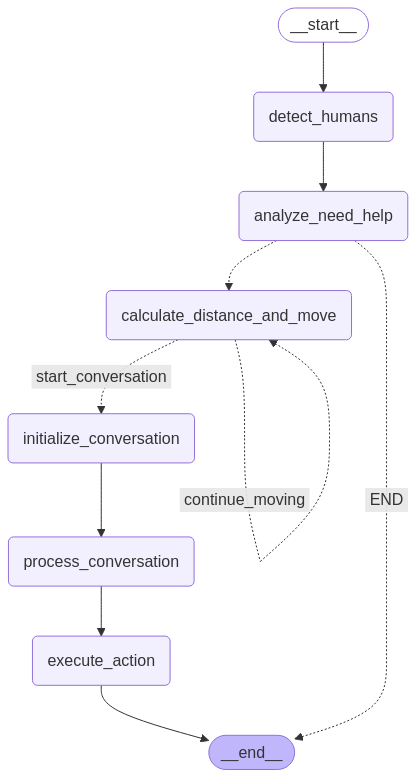

In [4]:
graph = create_graph()
display(Image(graph.get_graph().draw_mermaid_png()))